In [2]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution,
                       fiber_segments_phantom, pca_denoising,
                       evaluate_directions, evaluate_metric)

In [3]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

In [4]:
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

In [29]:
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
dir1 = np.zeros(fsigmas.size)
dir2 = np.zeros(dir1.shape)
dir3 = np.zeros(dir1.shape)
fa1 = np.zeros(dir1.shape)
fa2 = np.zeros(dir1.shape)
fa3 = np.zeros(dir1.shape)
md1 = np.zeros(dir1.shape)
md2 = np.zeros(dir1.shape)
md3 = np.zeros(dir1.shape)
mk1 = np.zeros(dir1.shape)
mk2 = np.zeros(dir1.shape)
mk3 = np.zeros(dir1.shape)
sig1 = np.zeros(dir1.shape)
sig2 = np.zeros(dir1.shape)
sig3 = np.zeros(dir1.shape)
ncomps1 = np.zeros(dir1.shape)
ncomps2 = np.zeros(dir1.shape)
ncomps3 = np.zeros(dir1.shape)

snr = 15
sigma = 50.0 /snr

for p in range(4):
    # ground truth is now the average of rician noise data
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])

    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_gt = _add_rician(Phantom.copy(), n1, n2)

    for rep in range(9):
        # add noise
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        n2 = np.random.normal(0, sigma, size=Phantom.shape)
        Phantom_gt = Phantom_gt + _add_rician(Phantom.copy(), n1, n2)
    Phantom_gt = Phantom_gt / 10
    
    dtiFgt = dtiM.fit(Phantom_gt)
    FAgt = dtiFgt.fa
    MDgt = dtiFgt.md 
    directionsgt = dtiFgt.directions
    dkiFgt = dkiM.fit(Phantom_gt)
    MKgt = dkiFgt.mk()

    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_noise = _add_rician(Phantom.copy(), n1, n2)

    # denoise and compare
    [Pden, sig, ncomps] = pca_denoising(Phantom_noise.copy(), psize=2)
    dtiF = dtiM.fit(Pden)
    FA = dtiF.fa
    MD = dtiF.md
    directions = dtiF.directions
    dkiF = dkiM.fit(Pden)
    MK = dkiF.mk()
    p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt[2:-2, 2:-2, 2:-2])
    dir1[p] = p1
    dir2[p] = p2
    dir3[p] = p3
    p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], FAgt[2:-2, 2:-2, 2:-2])
    fa1[p] = p1
    fa2[p] = p2
    fa3[p] = p3
    p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], MDgt[2:-2, 2:-2, 2:-2])
    md1[p] = p1
    md2[p] = p2
    md3[p] = p3
    p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], MKgt[2:-2, 2:-2, 2:-2])
    mk1[p] = p1
    mk2[p] = p2
    mk3[p] = p3
    p1, p2, p3 = np.percentile(sig[2:-2, 2:-2, 2:-2], [25, 50, 75])
    sig1[p] = p2
    sig2[p] = p2 - p1
    sig3[p] = p3 - p2
    ncomps = Phantom.shape[3] - ncomps
    p1, p2, p3 = np.percentile(ncomps[2:-2, 2:-2, 2:-2], [25, 50, 75])
    ncomps1[p] = p2
    ncomps2[p] = p2 - p1
    ncomps3[p] = p3 - p2

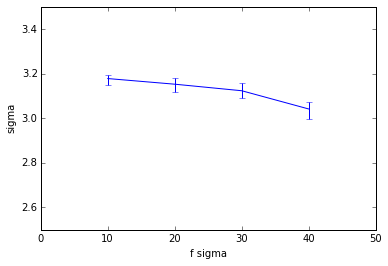

In [37]:
plt.errorbar(fsigmas, sig1, yerr=[sig2, sig3])
plt.axis([0, 50, 2.5, 3.5])
plt.xlabel('f sigma')
plt.ylabel('sigma')
fig = matplotlib.pyplot.gcf()
plt.show()

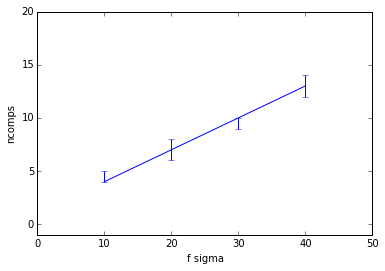

In [31]:
plt.errorbar(fsigmas, ncomps1, yerr=[ncomps2, ncomps3])
plt.axis([0, 50, -1, 20])
plt.xlabel('f sigma')
plt.ylabel('ncomps')
fig = matplotlib.pyplot.gcf()
plt.show()

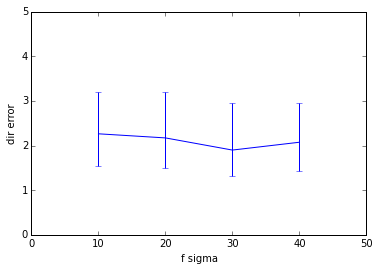

In [42]:
plt.errorbar(fsigmas, dir1, yerr=[dir2, dir3])
plt.axis([0, 50, 0, 5])
plt.xlabel('f sigma')
plt.ylabel('dir error')
fig = matplotlib.pyplot.gcf()
plt.show()

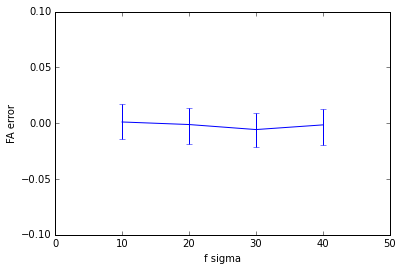

In [46]:
plt.errorbar(fsigmas, fa1, yerr=[fa2, fa3])
plt.axis([0, 50, -0.1, 0.1])
plt.xlabel('f sigma')
plt.ylabel('FA error')
fig = matplotlib.pyplot.gcf()
plt.show()

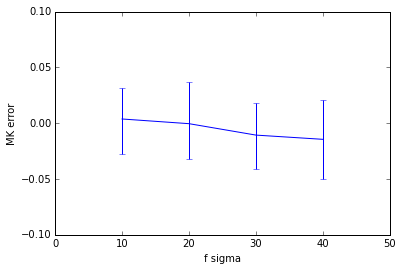

In [48]:
plt.errorbar(fsigmas, mk1, yerr=[mk2, mk3])
plt.axis([0, 50, -0.1, 0.1])
plt.xlabel('f sigma')
plt.ylabel('MK error')
fig = matplotlib.pyplot.gcf()
plt.show()